# Sanfrancisco Test Vis
##Smaller heading

#

I would like to investigate the correlation between the time of day and the number of police incidents which were recorded  during the summer of 2014 in San Francisco. I suspect that there would be more incidents during the evening than the day. 

To see if this suspicion is true and if there are any other correlations we created this Jupyter notebook. Initially we load the San Francisco incidents dataset using pandas. We need to convert the date columns into a datetime column so that we can query it. We also split the time column into an hour and minute column to help quering.

In [2]:
import pandas as pd
df = pd.read_csv('sanfrancisco_incidents_summer_2014.csv', sep=",")
df['Date'] =  pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M').dt.minute

# Group by hour
df_HOUR = df.groupby(pd.Grouper(key="Hour")).count().reset_index()

We also would like the find the hour in the day with the most and least number of occurrences for each city.

In [5]:
def rotateTime(x):
    return x + 24 if (x <= 5) else x;

df_HOUR['Hour'] = df_HOUR['Hour'].transform(rotateTime)
df_HOUR = df_HOUR.sort_values(by=['Hour'], ascending=True)

minHour = df_HOUR.loc[df_HOUR['IncidntNum'].idxmin()].Hour
maxHour = df_HOUR.loc[df_HOUR['IncidntNum'].idxmax()].Hour

print "San Francisco - min :" + str(minHour%24) + " max : " + str(maxHour%24)

minHour = rotateTime(minHour);
maxHour = rotateTime(maxHour);

San Francisco - min :4 max : 18


In [6]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.models import FuncTickFormatter, Span, ColumnDataSource, Range1d, LinearAxis
from bokeh.transform import cumsum
from math import pi

output_notebook()

p = figure(title="Total number of police incidents at each hour throughout the summer of 2014")

p.line(x=df_HOUR["Hour"],y=df_HOUR["IncidntNum"], line_width=6, line_color="Green")

SF_MIN = Span(location=minHour, dimension='height', line_color='Green', line_width=2)
SF_MAX = Span(location=maxHour, dimension='height', line_color='Green', line_width=2)
p.renderers.extend([SF_MIN, SF_MAX])

timeFormatter = FuncTickFormatter(code="""
    var s = "0" + ((tick%1)*60.0).toFixed(0);
    return (tick % 24).toFixed(0) + ":" + s.substr(s.length-2);
""")

p.yaxis.axis_label = "Number of Incidents"
p.xaxis.axis_label = "Time of Incident"
p.xaxis[0].formatter = timeFormatter

show(p)

Loading BokehJS ...

From the graph above it can be seen that in San Francisco the peak time for police incidents is 18:00 while the lowest 
number of incidents occur at 4:00. This is as I suspected that more crimes occur in the evening than during the day (which can also be seen by the sinusodal shape of the graph. However, what is unexpected is that the peak occurs so early 18:00 , when it is still light during the summer months. 

Even more suprisingly in Seattle where the peak time is 13:00 which is much earlier than my initial suspicions. 

In [13]:
dfDescriptGROUP = df.groupby(pd.Grouper(key="Descript"))[["IncidntNum"]].count()
dfDescriptGROUP = dfDescriptGROUP.sort_values(by=["IncidntNum"], ascending=False)
print dfDescriptGROUP

                                                  IncidntNum
Descript                                                    
GRAND THEFT FROM LOCKED AUTO                            3766
STOLEN AUTOMOBILE                                       1350
LOST PROPERTY                                           1202
PETTY THEFT OF PROPERTY                                 1125
WARRANT ARREST                                           980
PETTY THEFT FROM LOCKED AUTO                             955
BATTERY                                                  903
FOUND PROPERTY                                           757
GRAND THEFT FROM UNLOCKED AUTO                           681
SUSPICIOUS OCCURRENCE                                    677
FOUND PERSON                                             637
INVESTIGATIVE DETENTION                                  559
GRAND THEFT OF PROPERTY                                  485
THREATS AGAINST LIFE                                     473
ENROUTE TO OUTSIDE JURIS

In [15]:
# prepare data for our graphs - 
listOfCategories = ["ROBBERY","THEFT", "ASSAULT", "POSSESSION", "SALE", "HOMICIDE", "BATTERY", "LOST", "STOLEN" ];

data = {
    "categories": listOfCategories,
    "min":[],
    "max":[],
    "totIncidents":[],
    "incidentTypes":[],
}

def extractDetails(df):
    data['incidentTypes'].append(df['Descript'].unique())
    data['totIncidents'].append(len(df))
    df_Hour = df.groupby(pd.Grouper(key="Hour")).count().reset_index()
    data['max'].append(df_Hour.loc[df_Hour['IncidntNum'].idxmax()].Hour)
    data['min'].append(df_Hour.loc[df_Hour['IncidntNum'].idxmax()].Hour)

def isInNoCategory(x):
    return True if not any(s in x['Descript'] for s in listOfCategories) else False
 
#Extract only entries for each category then group by hour and get the hour with most incidents and least    
for c in data["categories"]:
    df_Filtered = df[df.apply(lambda x: c in x['Descript'], axis=1, result_type='reduce')]
    extractDetails(df_Filtered)

# Get all entries which don't fit in any category   
df_Filtered_Other = df[df.apply(isInNoCategory, axis=1, result_type='reduce')]
data['categories'].append("OTHER")
extractDetails(df_Filtered_Other)


In [19]:
from bokeh.palettes import Category20

allIncidents = float(sum(data['totIncidents']))
data['percent'] = map(lambda x: '{0:.2f}'.format(x/allIncidents*100.0) + "%", data['totIncidents'])
data['angle'] = map(lambda x: x/allIncidents*2*pi, data['totIncidents'])
data['color'] = Category20[len(data['categories'])]

p = figure(plot_height=350, title="Proportion of incident categories", toolbar_location=None,
        tools="hover", tooltips="@categories: @percent")

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='categories', source=data)
p.axis.visible = None
p.xgrid.visible = False
p.ygrid.visible = False
show(p)

In [28]:
from bokeh.layouts import row
from bokeh.models import FuncTickFormatter

data_MAX = {
     'categories' : list(data['categories']),
     'max': list(data['max']), 
     'colour' : ['blue']*len(data['max'])
    }

# Add the average
data_MAX["categories"].append('AVERAGE')
data_MAX["max"].append(maxHour)
data_MAX["colour"].append("green")

df_Categories = pd.DataFrame(data_MAX, columns=data_MAX.keys())
# rotate the time
df_Categories['max'] = df_Categories['max'].transform(rotateTime)
df_Categories['max_Time'] = map(lambda x: str(x%24).zfill(2)+":00", df_Categories['max'])

df_Categories = df_Categories.sort_values(by=['max'], ascending=True)

p = figure(title="Total number of police incidents at each hour throughout the summer of 2014", 
            y_range=df_Categories["categories"], tools="hover", tooltips="@categories: @max_Time")
p.hbar(height=0.8, y='categories', right="max", left=6, source=df_Categories, fill_color="colour")
p.xaxis.formatter = timeFormatter
p.xaxis.axis_label = "Peak time for incident categories"
show(p)


<IPython.core.display.Javascript object>


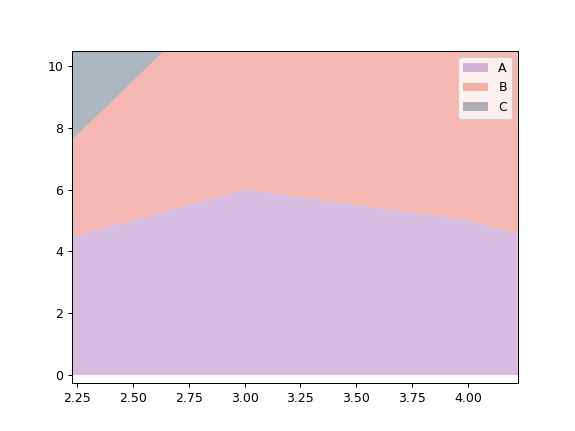

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

# Your x and y axis
x=range(1,6)
y=[ [10,4,6,5,3], [12,2,7,10,1], [8,18,5,7,6] ]
 
# create your palette
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]
plt.stackplot(x,y, labels=['A','B','C'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')

plt.show()